# Exploring Sierra Nevada Weather Data

In this notebook, I am exploring a dataset on precipitation in the Sierra Nevada that ranges from 1970 to 2019. I obtained the dataset from Kaggle, though it was ultimately obtained from UC Berkeley’s Central Sierra Snow Lab. 

I will ultimately create interactive apps using the streamlit library.

First I will process the data - change datatypes, fix column names, check for duplicates. I will have to deal with missing data and unreasonable outliers, and read through the remarks to make any necessary corrections to the data. After that I will save my revised dataset into a new csv that my app.py file can use directly.

I may explore the data at the end of this notebook, but I intend to play with visualizations primarily inside my app.py file so that I can see updates in real time.

In [1]:
import pandas as pd
import plotly.express as px


In [2]:
df = pd.read_csv('donner_pass.csv')

In [3]:
display(df.head())

,Date,Air Temp Max (C),Air Temp Min (C),24-hour Total Precip (mm),Season Total Precip (mm),% of Precip as Snow,% of Precip as Rain,New Snow (cm),Season Total Snow (cm),Snowpack depth (cm),Snow Water Equivalent (cm),Remarks
0,1970-10-01,22.2,4.995,0,0.0,--,--,0,0.0,0,0,NaN
1,1970-10-02,24.42,4.995,0,0.0,NaN,NaN,0,0.0,0,0,NaN
2,1970-10-03,23.31,5.55,0,0.0,NaN,NaN,0,0.0,0,0,NaN
3,1970-10-04,22.755,3.33,0,0.0,NaN,NaN,0,0.0,0,0,NaN
4,1970-10-05,17.205,3.33,0,0.0,NaN,NaN,0,0.0,0,0,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17897 entries, 0 to 17896
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        17897 non-null  object 
 1   Air Temp Max (C)            17897 non-null  object 
 2   Air Temp Min (C)            17897 non-null  object 
 3   24-hour Total Precip (mm)   17894 non-null  object 
 4   Season Total Precip (mm)    17896 non-null  float64
 5   % of Precip as Snow         2809 non-null   object 
 6   % of Precip as Rain         1862 non-null   object 
 7   New Snow (cm)               17896 non-null  object 
 8   Season Total Snow (cm)      17897 non-null  object 
 9   Snowpack depth (cm)         17895 non-null  object 
 10  Snow Water Equivalent (cm)  17862 non-null  object 
 11  Remarks                     201 non-null    object 
dtypes: float64(1), object(11)
memory usage: 1.6+ MB


Many of these columns are objects when they should be floats or datetime. Temperature is in C, I would like it to be in F. Some columns are full of NaNs, and I do not feel these columns are necessary for my purposes. Column names are messy.

## Preprocess data

In [5]:
# Change column names
print(df.columns)
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('-', '_')
df = df.rename(columns={'24_hour_total_precip_mm':'daily_precip_mm'})
print(df.columns)

Index(['Date', 'Air Temp Max (C)', 'Air Temp Min (C)',
       '24-hour Total Precip (mm)', 'Season Total Precip (mm)',
       '% of Precip as Snow', '% of Precip as Rain', 'New Snow (cm)',
       'Season Total Snow (cm)', 'Snowpack depth (cm)',
       'Snow Water Equivalent (cm)', 'Remarks'],
      dtype='object')
Index(['date', 'air_temp_max_c', 'air_temp_min_c', 'daily_precip_mm',
       'season_total_precip_mm', '%_of_precip_as_snow', '%_of_precip_as_rain',
       'new_snow_cm', 'season_total_snow_cm', 'snowpack_depth_cm',
       'snow_water_equivalent_cm', 'remarks'],
      dtype='object')


C:\Users\jncol\AppData\Local\Temp\ipykernel_18956\159129894.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('-', '_')
C:\Users\jncol\AppData\Local\Temp\ipykernel_18956\159129894.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('-', '_')


In [6]:
# Drop unneeded columns
df = df.drop(['%_of_precip_as_snow', '%_of_precip_as_rain'], axis=1)

In [7]:
# Check for duplicate dates - it appears there are no duplicate rows in the dataset
df.duplicated(subset='date').sum()

0

Let's focus on datatypes now

In [8]:
# Change to datetime
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')

In [9]:
# Are there non-number values in the temps and daily precip columns?
# print(df.air_temp_min_c.unique())
# print(df.daily_precip_mm.unique())


# It seems there is a trend of '--' and 'T' values in the measurement columns
# '--' values we can change to nans
# National Weather Service designates trace amounts (<0.25 mm) as 'T', so let's change these to 0

# Let's go through each column and replace values/change datatypes for each column that is applicable
for column in df.columns:
    df[column] = df[column].replace('--', 'nan')
    df[column] = df[column].replace('T', '0')
    df[column] = df[column].astype('float32', errors='ignore')

In [10]:
# Are there non-number values in the temps and daily precip columns?
# print(df.air_temp_min_c.unique())
# print(df.daily_precip_mm.unique())

# Replace '--' values with NaNs, as 0 is not appropriate
df[['air_temp_min_c', 'air_temp_max_c', 'daily_precip_mm']] = \
df[['air_temp_min_c', 'air_temp_max_c', 'daily_precip_mm']].replace('--', 'nan')

# Replace 'T' values in precip column with '0' - according to the National Weather Service, "trace" amounts of precip
# are less than 0.25 mm
df[['daily_precip_mm', 'new_snow_cm']] = df[['daily_precip_mm', 'new_snow_cm']].replace('T', 0)

# Change datatypes to floats
df[['air_temp_min_c', 'air_temp_max_c', 'daily_precip_mm']] = \
df[['air_temp_min_c', 'air_temp_max_c', 'daily_precip_mm']].astype('float32')

# Verify success
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17897 entries, 0 to 17896
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      17897 non-null  datetime64[ns]
 1   air_temp_max_c            17821 non-null  float32       
 2   air_temp_min_c            17832 non-null  float32       
 3   daily_precip_mm           17887 non-null  float32       
 4   season_total_precip_mm    17896 non-null  float32       
 5   new_snow_cm               17896 non-null  object        
 6   season_total_snow_cm      17859 non-null  float32       
 7   snowpack_depth_cm         16161 non-null  float32       
 8   snow_water_equivalent_cm  17862 non-null  object        
 9   remarks                   201 non-null    object        
dtypes: datetime64[ns](1), float32(6), object(3)
memory usage: 978.9+ KB


In [11]:
# Hmmm new_snow_cm did not convert, let's look into this one further

# df.new_snow_cm = df.new_snow_cm.astype('float32') # ValueError: could not convert string to float: '.'

# I want to find the rows above and below that '.' value to decide how much new snow was received that day
print(df[df.new_snow_cm == '.'].index)
display(df.iloc[11087:11090])
# Looks like 0 snowfall that day

df.new_snow_cm = df.new_snow_cm.where(df.new_snow_cm != '.', other=0) # Replace '.' values with 0

# Verify success
print(df[df.new_snow_cm == '.'].index)
display(df.iloc[11087:11090])

df.new_snow_cm = df.new_snow_cm.astype('float32') # Finally change the datatype to float

Int64Index([11088], dtype='int64')


,date,air_temp_max_c,air_temp_min_c,daily_precip_mm,season_total_precip_mm,new_snow_cm,season_total_snow_cm,snowpack_depth_cm,snow_water_equivalent_cm,remarks
11087,2001-02-07,-3.0,-10.0,3.0,396.0,4.5,382.0,94.0,27.1,NaN
11088,2001-02-08,4.0,-11.0,2.0,398.0,.,382.0,90.5,nan,NaN
11089,2001-02-09,-4.0,-7.0,41.0,439.0,36,418.0,113.0,27.4,NaN


Int64Index([], dtype='int64')


,date,air_temp_max_c,air_temp_min_c,daily_precip_mm,season_total_precip_mm,new_snow_cm,season_total_snow_cm,snowpack_depth_cm,snow_water_equivalent_cm,remarks
11087,2001-02-07,-3.0,-10.0,3.0,396.0,4.5,382.0,94.0,27.1,NaN
11088,2001-02-08,4.0,-11.0,2.0,398.0,0,382.0,90.5,nan,NaN
11089,2001-02-09,-4.0,-7.0,41.0,439.0,36,418.0,113.0,27.4,NaN


In [12]:
# snow_water_equivalent_cm also did not convert

# df.snow_water_equivalent_cm = df.snow_water_equivalent_cm.astype('float32') # ValueError: could not convert string to float: "0'0"

df.snow_water_equivalent_cm = df.snow_water_equivalent_cm.where(df.snow_water_equivalent_cm != "0'0", other=0) # Replace "0'0" values with 0

df.snow_water_equivalent_cm = df.snow_water_equivalent_cm.astype('float32')

In [13]:
df.describe()

,air_temp_max_c,air_temp_min_c,daily_precip_mm,season_total_precip_mm,new_snow_cm,season_total_snow_cm,snowpack_depth_cm,snow_water_equivalent_cm
count,17821.000000,17832.000000,17887.000000,17896.000000,17640.000000,17859.000000,16161.000000,12283.000000
mean,12.625631,-0.905326,4.419010,1053.920654,2.731730,652.303650,69.109367,18.296000
std,9.453617,6.327107,12.612042,704.740356,9.221365,447.555115,101.595535,37.669384
min,-12.210000,-25.530001,-1.016000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.440000,-5.000000,0.000000,456.000000,0.000000,233.000000,0.000000,0.000000
50%,12.000000,-1.000000,0.000000,1002.500000,0.000000,655.500000,0.000000,0.000000
75%,21.000000,4.000000,1.000000,1545.000000,0.000000,983.640015,124.500000,18.394800
max,37.000000,87.000000,164.845993,3064.000000,132.080002,1704.300049,920.000000,1401.000000


In [14]:
# Convert Celsius temps to Fahrenheit temps, drop Celsius temps

def celsius_to_fahrenheit(celsius):
    fahrenheit = (celsius * 1.8) + 32
    return fahrenheit

df = df.rename(columns={'air_temp_max_c':'air_temp_max_f', 'air_temp_min_c':'air_temp_min_f'})
df.air_temp_max_f = df.air_temp_max_f.apply(celsius_to_fahrenheit).astype('float32')
df.air_temp_min_f = df.air_temp_min_f.apply(celsius_to_fahrenheit).astype('float32')

In [15]:
# Let's check that all values make sense.
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17897 entries, 0 to 17896
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      17897 non-null  datetime64[ns]
 1   air_temp_max_f            17821 non-null  float32       
 2   air_temp_min_f            17832 non-null  float32       
 3   daily_precip_mm           17887 non-null  float32       
 4   season_total_precip_mm    17896 non-null  float32       
 5   new_snow_cm               17640 non-null  float32       
 6   season_total_snow_cm      17859 non-null  float32       
 7   snowpack_depth_cm         16161 non-null  float32       
 8   snow_water_equivalent_cm  12283 non-null  float32       
 9   remarks                   201 non-null    object        
dtypes: datetime64[ns](1), float32(8), object(1)
memory usage: 839.0+ KB


,air_temp_max_f,air_temp_min_f,daily_precip_mm,season_total_precip_mm,new_snow_cm,season_total_snow_cm,snowpack_depth_cm,snow_water_equivalent_cm
count,17821.000000,17832.000000,17887.000000,17896.000000,17640.000000,17859.000000,16161.000000,12283.000000
mean,54.726135,30.370413,4.419010,1053.920654,2.731730,652.303650,69.109367,18.296000
std,17.016966,11.389205,12.612042,704.740356,9.221365,447.555115,101.595535,37.669384
min,10.022000,-13.954001,-1.016000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.992001,23.000000,0.000000,456.000000,0.000000,233.000000,0.000000,0.000000
50%,53.599998,30.200001,0.000000,1002.500000,0.000000,655.500000,0.000000,0.000000
75%,69.800003,39.200001,1.000000,1545.000000,0.000000,983.640015,124.500000,18.394800
max,98.599998,188.600006,164.845993,3064.000000,132.080002,1704.300049,920.000000,1401.000000


In [16]:
# Hmm the max air temps look reasonable, but the min air temps do not look reasonable at the high end
print(df.air_temp_min_f[~df.air_temp_min_f.isna()].sort_values().tail())

# Got it. There is one unrealistically high value. Let's look at that row and nearby rows.
display(df.iloc[16705:16708])

# Let's just replace it by hand with the average of the surrounding min temps
df.loc[16706, 'air_temp_min_f'] = (df.loc[16705, 'air_temp_min_f'] + df.loc[16707, 'air_temp_min_f']) / 2

# Verify success
display(df.iloc[16705:16708])

7622      60.799999
17140     62.599998
6159      69.961998
6158      70.960999
16706    188.600006
Name: air_temp_min_f, dtype: float32


,date,air_temp_max_f,air_temp_min_f,daily_precip_mm,season_total_precip_mm,new_snow_cm,season_total_snow_cm,snowpack_depth_cm,snow_water_equivalent_cm,remarks
16705,2016-06-26,78.800003,44.599998,0.0,1720.0,0.0,954.0,0.0,0.0,NaN
16706,2016-06-27,78.800003,188.600006,0.0,1720.0,0.0,954.0,0.0,0.0,NaN
16707,2016-06-28,80.599998,46.400002,0.0,1720.0,0.0,954.0,0.0,0.0,NaN


,date,air_temp_max_f,air_temp_min_f,daily_precip_mm,season_total_precip_mm,new_snow_cm,season_total_snow_cm,snowpack_depth_cm,snow_water_equivalent_cm,remarks
16705,2016-06-26,78.800003,44.599998,0.0,1720.0,0.0,954.0,0.0,0.0,NaN
16706,2016-06-27,78.800003,45.500000,0.0,1720.0,0.0,954.0,0.0,0.0,NaN
16707,2016-06-28,80.599998,46.400002,0.0,1720.0,0.0,954.0,0.0,0.0,NaN


In [17]:
# snow_water_equivalent_cm also looks like it has an unusually high number
print(df.snow_water_equivalent_cm[~df.snow_water_equivalent_cm.isna()].sort_values().tail())

display(df.iloc[12122:12125]) # Looking at that row and nearby rows

# Replace that value with the average of the above and below rows
df.loc[12123, 'snow_water_equivalent_cm'] = (df.loc[12122, 'snow_water_equivalent_cm'] + df.loc[12124, 'snow_water_equivalent_cm']) / 2

display(df.loc[12123])

8980      194.500000
8982      195.800003
8971      196.899994
12241     355.600006
12123    1401.000000
Name: snow_water_equivalent_cm, dtype: float32


,date,air_temp_max_f,air_temp_min_f,daily_precip_mm,season_total_precip_mm,new_snow_cm,season_total_snow_cm,snowpack_depth_cm,snow_water_equivalent_cm,remarks
12122,2003-12-09,30.200001,15.800000,12.0,253.0,0.0,138.5,40.0,10.6,NaN
12123,2003-12-10,30.200001,24.799999,46.0,299.0,54.5,193.0,78.0,1401.0,NaN
12124,2003-12-11,32.000000,10.400000,14.0,313.0,17.0,210.0,95.0,17.5,NaN


date                        2003-12-10 00:00:00
air_temp_max_f                        30.200001
air_temp_min_f                        24.799999
daily_precip_mm                            46.0
season_total_precip_mm                    299.0
new_snow_cm                                54.5
season_total_snow_cm                      193.0
snowpack_depth_cm                          78.0
snow_water_equivalent_cm                  14.05
remarks                                     NaN
Name: 12123, dtype: object

In [18]:
# Also, the minimum value of daily_precip should be 0, not -1. Let's change that to 0.
df.daily_precip_mm = df.daily_precip_mm.where(df.daily_precip_mm >= 0, other = 0)

In [19]:
df.describe()

,air_temp_max_f,air_temp_min_f,daily_precip_mm,season_total_precip_mm,new_snow_cm,season_total_snow_cm,snowpack_depth_cm,snow_water_equivalent_cm
count,17821.000000,17832.000000,17897.000000,17896.000000,17640.000000,17859.000000,16161.000000,12283.000000
mean,54.726135,30.362389,4.416597,1053.920654,2.731730,652.303650,69.109367,18.183083
std,17.016966,11.327939,12.609275,704.740356,9.221365,447.555115,101.595535,35.543907
min,10.022000,-13.954001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.992001,23.000000,0.000000,456.000000,0.000000,233.000000,0.000000,0.000000
50%,53.599998,30.200001,0.000000,1002.500000,0.000000,655.500000,0.000000,0.000000
75%,69.800003,39.200001,1.000000,1545.000000,0.000000,983.640015,124.500000,18.364201
max,98.599998,70.960999,164.845993,3064.000000,132.080002,1704.300049,920.000000,355.600006


In [20]:
# I am looking that this table and wondering why the meter measurements are different units.

# Let's convert all mm measurements to cm for consistency.
df[['daily_precip_mm', 'season_total_precip_mm']] = df[['daily_precip_mm', 'season_total_precip_mm']] / 10
df = df.rename(columns={'daily_precip_mm':'daily_precip_cm', 'season_total_precip_mm':'season_total_precip_cm'})

df.describe()

,air_temp_max_f,air_temp_min_f,daily_precip_cm,season_total_precip_cm,new_snow_cm,season_total_snow_cm,snowpack_depth_cm,snow_water_equivalent_cm
count,17821.000000,17832.000000,17897.000000,17896.000000,17640.000000,17859.000000,16161.000000,12283.000000
mean,54.726135,30.362389,0.441660,105.392075,2.731730,652.303650,69.109367,18.183083
std,17.016966,11.327939,1.260997,70.474091,9.221365,447.555115,101.595535,35.543907
min,10.022000,-13.954001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.992001,23.000000,0.000000,45.599998,0.000000,233.000000,0.000000,0.000000
50%,53.599998,30.200001,0.000000,100.250000,0.000000,655.500000,0.000000,0.000000
75%,69.800003,39.200001,0.100000,154.500000,0.000000,983.640015,124.500000,18.364201
max,98.599998,70.960999,16.484600,306.399994,132.080002,1704.300049,920.000000,355.600006


In [21]:
# I want to add a year-month column in case I decide to group data by month later on
df['year_month'] = df.date.dt.strftime('%Y-%m')

# And generic year, month columns
df['month'] = df.date.dt.month
df['year'] = df.date.dt.year
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17897 entries, 0 to 17896
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      17897 non-null  datetime64[ns]
 1   air_temp_max_f            17821 non-null  float32       
 2   air_temp_min_f            17832 non-null  float32       
 3   daily_precip_cm           17897 non-null  float32       
 4   season_total_precip_cm    17896 non-null  float32       
 5   new_snow_cm               17640 non-null  float32       
 6   season_total_snow_cm      17859 non-null  float32       
 7   snowpack_depth_cm         16161 non-null  float32       
 8   snow_water_equivalent_cm  12283 non-null  float32       
 9   remarks                   201 non-null    object        
 10  year_month                17897 non-null  object        
 11  month                     17897 non-null  int64         
 12  year              

I want to skim the remarks and make any relevant data edits.

In [22]:
display(df.remarks[~df.remarks.isna()])
display(df.remarks.unique())

43                                  patches
44                                  patches
45                                  patches
46                                  patches
47                                  patches
                        ...                
8285     new snow 9.5 is 2 day accumulation
11113                                   Max
11490                                   Max
11894                                   Max
11908                                   Max
Name: remarks, Length: 201, dtype: object

array([nan, 'patches', 'wet snow. Small amt. of rain (drizzle)',
       'large patches', 'small patches', 'no precip. Pen was stuck',
       'clock stopped', '0.02 in lost to evaporation', 'mt',
       'loss from evaporation', 'snow filled around tube', 'approx.',
       'Feb 9-11: Max 48 F, Min 18 F.', '0.01 in condensation',
       '0.03 in condensation', 'changed charge', '2.5 inch overflow',
       'on chart, pen moved, not precipt.', 'charge changed', 'approx',
       'tipping bucket.', 'loss due to evap.', 'charger changed',
       'Gage recalibrated  so tab new reading 4.73 on chart.',
       'Charge change. New reading 3.15', 'reverse gauge malfunction',
       'charge changed at 1320.', 'charge change at 1015 est.',
       'charge change due to diurnal variation.', 'charge changed.',
       'charge changed 1500 pst', 'gauge recalibrated 5.98-5.82',
       'charge changed 1340 pst.', 'chart readjusted.',
       '74= accumulation over 4 day period.', '*', 'greater than 10.5.',
 

I will only be editing the data directly related to the remarks. I will not be adjusting any other data, even related data.

- For example, if I adjust the new snowfall value based on a remark, I will not adjust the total snow or snowpack depth, etc.

In [23]:
# I will fill in the missing values that this remark refers to
display(df[df.remarks=='Feb 9-11: Max 48 F, Min 18 F.'])
df.loc[3053:3055, 'air_temp_max_f'] = 48.0
df.loc[3053:3055, 'air_temp_min_f'] = 18.0
df.iloc[3052:3057]

,date,air_temp_max_f,air_temp_min_f,daily_precip_cm,season_total_precip_cm,new_snow_cm,season_total_snow_cm,snowpack_depth_cm,snow_water_equivalent_cm,remarks,year_month,month,year
3053,1979-02-09,NaN,NaN,0.0,46.628601,0.0,412.73999,110.032799,30.835600,"Feb 9-11: Max 48 F, Min 18 F.",1979-02,2,1979
3054,1979-02-10,NaN,NaN,0.0,46.628601,0.0,412.73999,105.155998,29.870399,"Feb 9-11: Max 48 F, Min 18 F.",1979-02,2,1979
3055,1979-02-11,NaN,NaN,0.0,46.628601,0.0,412.73999,104.241600,29.768801,"Feb 9-11: Max 48 F, Min 18 F.",1979-02,2,1979


,date,air_temp_max_f,air_temp_min_f,daily_precip_cm,season_total_precip_cm,new_snow_cm,season_total_snow_cm,snowpack_depth_cm,snow_water_equivalent_cm,remarks,year_month,month,year
3052,1979-02-08,45.986000,16.015999,0.0,46.628601,0.0,412.73999,112.471199,30.708599,NaN,1979-02,2,1979
3053,1979-02-09,48.000000,18.000000,0.0,46.628601,0.0,412.73999,110.032799,30.835600,"Feb 9-11: Max 48 F, Min 18 F.",1979-02,2,1979
3054,1979-02-10,48.000000,18.000000,0.0,46.628601,0.0,412.73999,105.155998,29.870399,"Feb 9-11: Max 48 F, Min 18 F.",1979-02,2,1979
3055,1979-02-11,48.000000,18.000000,0.0,46.628601,0.0,412.73999,104.241600,29.768801,"Feb 9-11: Max 48 F, Min 18 F.",1979-02,2,1979
3056,1979-02-12,42.988998,34.997002,0.0,46.628601,0.0,412.73999,102.412804,29.743401,NaN,1979-02,2,1979


In [24]:
display(df[df.remarks=='74= accumulation over 4 day period.']) # This refers to the 7.4422 cm precip that day
df.iloc[4590:4594] # We can see that 0 precip is marked for the preceeding three days

# Let's just distribute this total evenly through these four days
df.loc[4590:4594, 'daily_precip_cm'] = df.loc[4593, 'daily_precip_cm'] / 4
df.iloc[4590:4594]

,date,air_temp_max_f,air_temp_min_f,daily_precip_cm,season_total_precip_cm,new_snow_cm,season_total_snow_cm,snowpack_depth_cm,snow_water_equivalent_cm,remarks,year_month,month,year
4593,1983-04-29,33.998001,27.004999,7.4422,216.905594,17.780001,1657.27002,447.040009,183.134003,74= accumulation over 4 day period.,1983-04,4,1983


,date,air_temp_max_f,air_temp_min_f,daily_precip_cm,season_total_precip_cm,new_snow_cm,season_total_snow_cm,snowpack_depth_cm,snow_water_equivalent_cm,remarks,year_month,month,year
4590,1983-04-26,35.995998,12.020000,1.86055,209.463409,0.000000,1601.390015,435.254395,178.003204,NaN,1983-04,4,1983
4591,1983-04-27,34.997002,28.004000,1.86055,209.463409,7.620000,1609.010010,419.404785,175.412399,NaN,1983-04,4,1983
4592,1983-04-28,33.998001,28.004000,1.86055,209.463409,30.480000,1639.489990,441.959991,178.815994,NaN,1983-04,4,1983
4593,1983-04-29,33.998001,27.004999,1.86055,216.905594,17.780001,1657.270020,447.040009,183.134003,74= accumulation over 4 day period.,1983-04,4,1983


In [25]:
display(df[df.remarks=='new snow 6.3 is accumulation of previous 3 days'])
df.iloc[8086:8090] # Zero precip is marked for preceeding three days

# Distribute 6.3 amongst those three days and zero out the 6.3 day
df.loc[8086:8089, 'new_snow_cm'] = df.loc[8089, 'new_snow_cm'] / 3
df.loc[8089, 'new_snow_cm'] = 0
df.iloc[8086:8090]

,date,air_temp_max_f,air_temp_min_f,daily_precip_cm,season_total_precip_cm,new_snow_cm,season_total_snow_cm,snowpack_depth_cm,snow_water_equivalent_cm,remarks,year_month,month,year
8089,1992-11-23,37.400002,19.4,0.0,20.200001,6.3,49.799999,8.9,NaN,new snow 6.3 is accumulation of previous 3 days,1992-11,11,1992


,date,air_temp_max_f,air_temp_min_f,daily_precip_cm,season_total_precip_cm,new_snow_cm,season_total_snow_cm,snowpack_depth_cm,snow_water_equivalent_cm,remarks,year_month,month,year
8086,1992-11-20,32.000000,17.600000,0.0,18.600000,2.1,43.500000,NaN,NaN,NaN,1992-11,11,1992
8087,1992-11-21,44.599998,21.200001,0.6,19.200001,2.1,43.500000,NaN,NaN,NaN,1992-11,11,1992
8088,1992-11-22,41.000000,21.200001,1.0,20.200001,2.1,43.500000,NaN,NaN,NaN,1992-11,11,1992
8089,1992-11-23,37.400002,19.400000,0.0,20.200001,0.0,49.799999,8.9,NaN,new snow 6.3 is accumulation of previous 3 days,1992-11,11,1992


In [26]:
display(df[df.remarks=='new snow 123 is 4 days of accumulation'])
df.iloc[8124:8128] # Nans are marked for the previous three days

# Distribute 123 amongst these four days
df.loc[8124:8128, 'new_snow_cm'] = df.loc[8127, 'new_snow_cm'] / 4
df.iloc[8124:8128]

,date,air_temp_max_f,air_temp_min_f,daily_precip_cm,season_total_precip_cm,new_snow_cm,season_total_snow_cm,snowpack_depth_cm,snow_water_equivalent_cm,remarks,year_month,month,year
8127,1992-12-31,30.200001,26.6,1.1,73.599998,123.0,464.100006,235.0,NaN,new snow 123 is 4 days of accumulation,1992-12,12,1992


,date,air_temp_max_f,air_temp_min_f,daily_precip_cm,season_total_precip_cm,new_snow_cm,season_total_snow_cm,snowpack_depth_cm,snow_water_equivalent_cm,remarks,year_month,month,year
8124,1992-12-28,33.799999,26.6,8.6,65.900002,30.75,341.100006,NaN,NaN,NaN,1992-12,12,1992
8125,1992-12-29,26.600000,19.4,5.5,71.400002,30.75,341.100006,NaN,NaN,NaN,1992-12,12,1992
8126,1992-12-30,26.600000,17.6,1.1,72.500000,30.75,341.100006,NaN,NaN,NaN,1992-12,12,1992
8127,1992-12-31,30.200001,26.6,1.1,73.599998,30.75,464.100006,235.0,NaN,new snow 123 is 4 days of accumulation,1992-12,12,1992


In [27]:
display(df[df.remarks=='new snow 9.5 is 2 day accumulation'])
df.iloc[8284:8286]

# Distribute 9.5 among the two days
df.loc[8284:8286, 'new_snow_cm'] = df.loc[8285, 'new_snow_cm'] / 2
df.iloc[8284:8286]

,date,air_temp_max_f,air_temp_min_f,daily_precip_cm,season_total_precip_cm,new_snow_cm,season_total_snow_cm,snowpack_depth_cm,snow_water_equivalent_cm,remarks,year_month,month,year
8285,1993-06-07,50.0,35.599998,0.3,210.399994,9.5,1270.699951,6.4,NaN,new snow 9.5 is 2 day accumulation,1993-06,6,1993


,date,air_temp_max_f,air_temp_min_f,daily_precip_cm,season_total_precip_cm,new_snow_cm,season_total_snow_cm,snowpack_depth_cm,snow_water_equivalent_cm,remarks,year_month,month,year
8284,1993-06-06,37.400002,30.200001,2.0,210.100006,4.75,1261.199951,NaN,NaN,NaN,1993-06,6,1993
8285,1993-06-07,50.000000,35.599998,0.3,210.399994,4.75,1270.699951,6.4,NaN,new snow 9.5 is 2 day accumulation,1993-06,6,1993


In [28]:
# Let's take one last look at the dataset
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17897 entries, 0 to 17896
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      17897 non-null  datetime64[ns]
 1   air_temp_max_f            17824 non-null  float32       
 2   air_temp_min_f            17835 non-null  float32       
 3   daily_precip_cm           17897 non-null  float32       
 4   season_total_precip_cm    17896 non-null  float32       
 5   new_snow_cm               17644 non-null  float64       
 6   season_total_snow_cm      17859 non-null  float32       
 7   snowpack_depth_cm         16161 non-null  float32       
 8   snow_water_equivalent_cm  12283 non-null  float32       
 9   remarks                   201 non-null    object        
 10  year_month                17897 non-null  object        
 11  month                     17897 non-null  int64         
 12  year              

,air_temp_max_f,air_temp_min_f,daily_precip_cm,season_total_precip_cm,new_snow_cm,season_total_snow_cm,snowpack_depth_cm,snow_water_equivalent_cm,month,year
count,17824.000000,17835.000000,17897.000000,17896.000000,17644.000000,17859.000000,16161.000000,12283.000000,17897.000000,17897.000000
mean,54.725002,30.360310,0.441764,105.392075,2.729071,652.303650,69.109367,18.183083,6.522993,1994.747444
std,17.016123,11.327967,1.260108,70.474091,9.172821,447.555115,101.595535,35.543907,3.448782,14.148982
min,10.022000,-13.954001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1970.000000
25%,40.741249,23.000000,0.000000,45.599998,0.000000,233.000000,0.000000,0.000000,4.000000,1982.000000
50%,53.599998,30.200001,0.000000,100.250000,0.000000,655.500000,0.000000,0.000000,7.000000,1995.000000
75%,69.800003,39.200001,0.100000,154.500000,0.000000,983.640015,124.500000,18.364201,10.000000,2007.000000
max,98.599998,70.960999,16.484600,306.399994,132.080002,1704.300049,920.000000,355.600006,12.000000,2019.000000


In [29]:
df.head()

,date,air_temp_max_f,air_temp_min_f,daily_precip_cm,season_total_precip_cm,new_snow_cm,season_total_snow_cm,snowpack_depth_cm,snow_water_equivalent_cm,remarks,year_month,month,year
0,1970-10-01,71.959999,40.991001,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1970-10,10,1970
1,1970-10-02,75.956001,40.991001,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1970-10,10,1970
2,1970-10-03,73.958000,41.990002,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1970-10,10,1970
3,1970-10-04,72.959000,37.993999,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1970-10,10,1970
4,1970-10-05,62.969002,37.993999,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1970-10,10,1970


Datatypes are how I want them, the values all make sense, and the remarks have been taken into account. I am done with preprocessing, now I can properly explore the data.

I am also saving the updated dataframe into a new csv file.

In [33]:
df.to_csv('processed_donner_pass.csv', index=False)

# EDA

array([[<Axes: xlabel='air_temp_max_f', ylabel='air_temp_max_f'>,
        <Axes: xlabel='air_temp_min_f', ylabel='air_temp_max_f'>,
        <Axes: xlabel='daily_precip_cm', ylabel='air_temp_max_f'>,
        <Axes: xlabel='season_total_precip_cm', ylabel='air_temp_max_f'>,
        <Axes: xlabel='new_snow_cm', ylabel='air_temp_max_f'>,
        <Axes: xlabel='season_total_snow_cm', ylabel='air_temp_max_f'>,
        <Axes: xlabel='snowpack_depth_cm', ylabel='air_temp_max_f'>,
        <Axes: xlabel='snow_water_equivalent_cm', ylabel='air_temp_max_f'>,
        <Axes: xlabel='month', ylabel='air_temp_max_f'>,
        <Axes: xlabel='year', ylabel='air_temp_max_f'>],
       [<Axes: xlabel='air_temp_max_f', ylabel='air_temp_min_f'>,
        <Axes: xlabel='air_temp_min_f', ylabel='air_temp_min_f'>,
        <Axes: xlabel='daily_precip_cm', ylabel='air_temp_min_f'>,
        <Axes: xlabel='season_total_precip_cm', ylabel='air_temp_min_f'>,
        <Axes: xlabel='new_snow_cm', ylabel='air_temp_min_f'

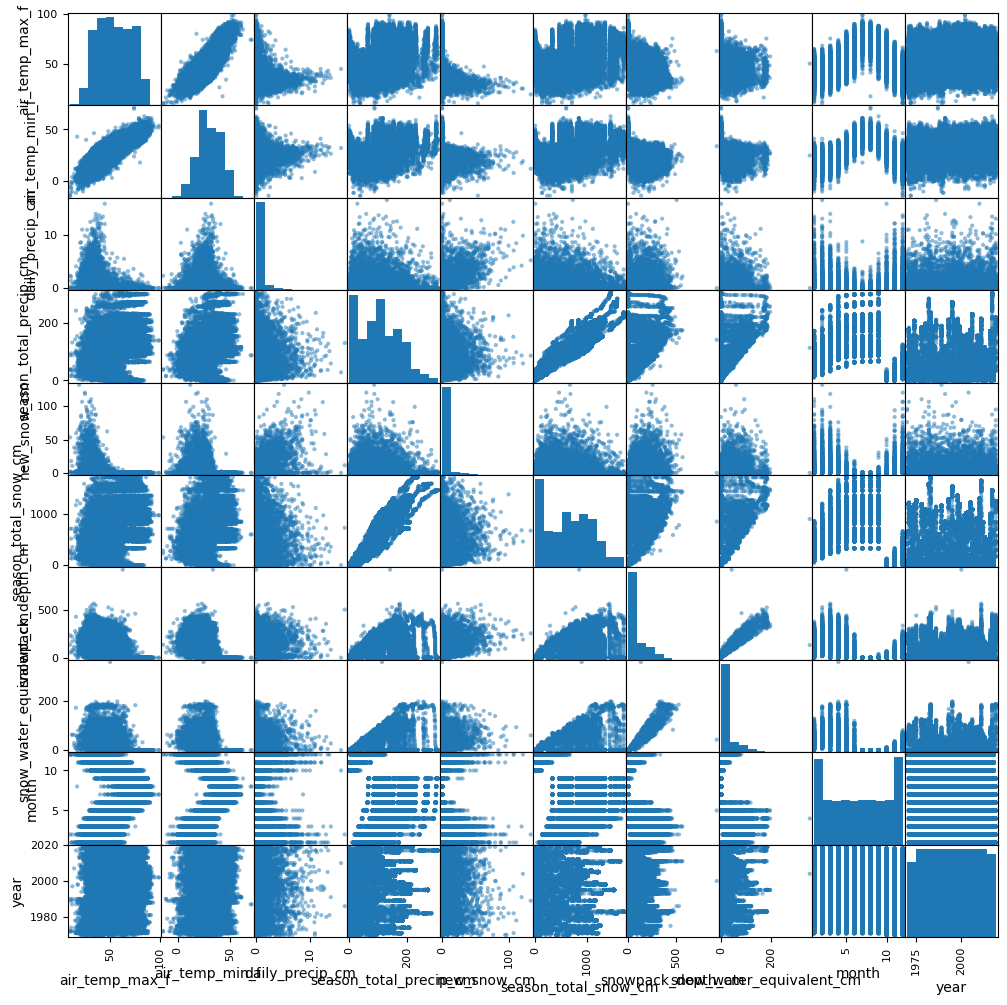

In [37]:
# Look for notable correlations or histograms
pd.plotting.scatter_matrix(df, figsize=(12, 12))

# Min and max air temps are highly correlated, as are total snow and total precipitation. I could compare one set of these histograms,
# and avoid comparing members of these sets against each other in a scatter plot

In [35]:
# First plot
year_input=2015
px.scatter(df.query('year==@year_input'), x='date',
                 y='new_snow_cm', labels={'new_snow_cm': 'new snow (cm)'})


In [36]:
# Second plot
month_input = 4
px.histogram(df.query('month==@month_input'),
                   x=['air_temp_max_f', 'air_temp_min_f'], labels={'value': 'degrees Fahrenheit'})

In [34]:
# Final plot
pivot_by_year = df.pivot_table(index='year', aggfunc='max',
                                   values=['snowpack_depth_cm', 'season_total_snow_cm', 'snow_water_equivalent_cm'])
fig = px.line(pivot_by_year, color_discrete_sequence=['red', 'green', 'blue'], labels={'value': 'amount of snow/water (cm)'})
fig.show()

# We see that the water equivalent of snow is less than the snowpack depth, which is less than the total snow for the season